In [1]:
from transformers import AutoModel, AutoTokenizer

c:\Users\SIVERMA\Documents\Experimenting\NLCHATBOT\NLCHATBOT\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = AutoTokenizer.from_pretrained("./jina-embeddings-v2-base-en",trust_remote_code = True)
model = AutoModel.from_pretrained("./jina-embeddings-v2-base-en",trust_remote_code = True)

In [3]:
# !pip install pypdf

In [4]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("brief_history_of_time.pdf")
pages = []
async for page in loader.alazy_load():
    pages.append(page.page_content)

In [5]:
len(pages[3].split(" "))

277

In [6]:
import requests
def chunk_using_api(text):
    url =  "https://tokenizer.jina.ai/"
    payload =  {
        "content" : text,
        "return_chunks" : "true",
        "max_chunk_length" : "1000"
    }
    response = requests.post(url,json = payload)
    response_data = response.json()

    chunks = response_data.get("chunks",[])

    chunks_position = response_data.get("chunks_positions",[])
    span_annaotation = [(start,end) for start, end in chunks_position]
    
    return chunks, span_annaotation


In [7]:
full_doc = ",".join(pages)
len(full_doc)

384183

In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing import List, Tuple

def split_text_with_indices(text: str, chunk_size: int, chunk_overlap: int) -> List[Tuple[str, int, int]]:
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        is_separator_regex=False
    )
    
    chunks = text_splitter.split_text(text)
    
    span_annaotation = []
    start_index = 0
    for chunk in chunks:
        chunk_start = text.find(chunk, start_index)
        chunk_end = chunk_start + len(chunk)
        span_annaotation.append((chunk_start, chunk_end))
        start_index = chunk_start + 1  # +1 to avoid finding the same chunk again
    
    return chunks,span_annaotation

In [9]:
texts_chunks, span_annaotation = split_text_with_indices(full_doc,1000,80)

In [10]:
texts_chunks[0][-20:], texts_chunks[1][:20] # overlap

('Carl Sagan. Instead,', 'I wrote a short piec')

In [11]:
span_annaotation[0],span_annaotation[1], span_annaotation[2]

((0, 624), (625, 1506), (1507, 2144))

# OR

In [181]:
def chunk_by_sentences(input_text: str, tokenizer: callable):
    inputs = tokenizer(input_text, return_tensors='pt', return_offsets_mapping=True)
    punctuation_mark_id = tokenizer.convert_tokens_to_ids('.')
    sep_id = tokenizer.convert_tokens_to_ids('[SEP]')
    token_offsets = inputs['offset_mapping'][0]
    token_ids = inputs['input_ids'][0]
    chunk_positions = [
        (i, int(start + 1))
        for i, (token_id, (start, end)) in enumerate(zip(token_ids, token_offsets))
        if token_id == punctuation_mark_id
        and (
            token_offsets[i + 1][0] - token_offsets[i][1] > 0
            or token_ids[i + 1] == sep_id
        )
    ]
    chunks = [
        input_text[x[1] : y[1]]
        for x, y in zip([(1, 0)] + chunk_positions[:-1], chunk_positions)
    ]
    span_annotations = [
        (x[0], y[0]) for (x, y) in zip([(1, 0)] + chunk_positions[:-1], chunk_positions)
    ]
    return chunks, span_annotations

In [182]:
texts_chunks, span_annaotation = chunk_by_sentences(full_doc,tokenizer)

In [184]:
texts_chunks[42],span_annaotation[42]

(' The death blow to the Aristotelian/Ptolemaictheory came in 1609.',
 (2160, 2180))

In [12]:
def late_chunking(model_output,span_annotation,max_length = None):
    token_embed = model_output[0]
    output = []

    for embeddings, annotaion in zip(token_embed,span_annotation):
        if max_length is not None:
            annotaion = [
                (start, min(end,max_length-1)) for start,end in annotaion if start < (max_length-1)
            ]

        pooled_embeddings = [
            embeddings[start:end].sum(dim=0) / (end -start)
            for start, end in annotaion 
            if (end - start) >= 1
        ]

        pooled_embeddings = [
            embeddings.detach().cpu().numpy() for embeddings in pooled_embeddings
        ]
        output.append(pooled_embeddings)

    return output

# Traditional chunking

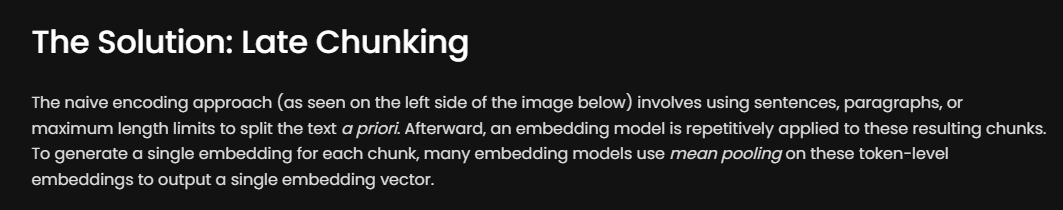

In [14]:
traditional_embed = model.encode(texts_chunks)

# Late Chunking

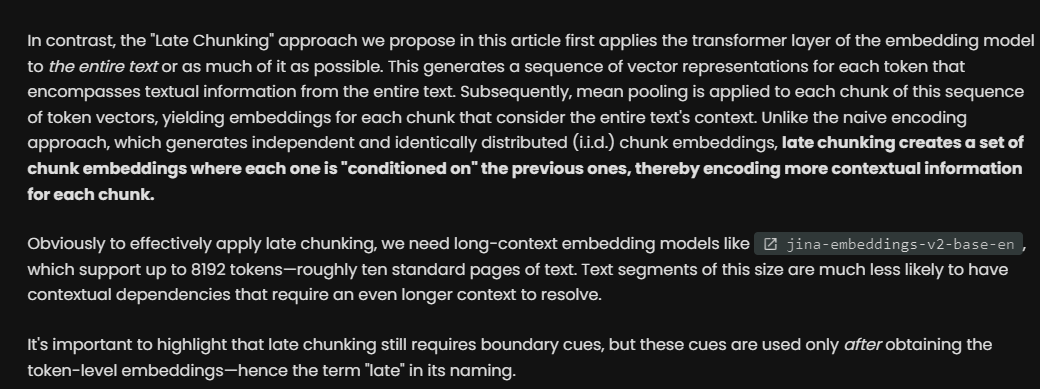

In [13]:
two_2_1 = [", ".join(texts_chunks[:i+3]) for i in range(0,len(texts_chunks),3)]
len(two_2_1[0])

2146

In [14]:
def createEmbeddings(chunck_compress_ratio):
    compress_text = [", ".join(texts_chunks[:i+chunck_compress_ratio]) for i in range(0,len(texts_chunks),chunck_compress_ratio)]
    embeddings = []
    for ith,chunk_comb in enumerate(compress_text):
        inputs = tokenizer(chunk_comb,return_tensors="pt",padding=True)
        model_output = model(**inputs)
        current_0th = span_annaotation[(ith*chunck_compress_ratio)][0]
        current_span = [(i[0]-current_0th,i[1]-current_0th) for i in span_annaotation[ith*chunck_compress_ratio:((ith + 1)*chunck_compress_ratio)]]
        print(ith, current_span,end="\r")
        embeddings.extend(late_chunking(model_output, [current_span])[0])
    
    return embeddings

In [ ]:
new_embeddings = createEmbeddings(3)

In [ ]:
len(new_embeddings),new_embeddings[0]